In [1]:
# Install the necessary dependencies
!pip install selenium
!apt update
!apt install chromium-chromedriver


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 19.7 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 https://cli.github.com/packages stable InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,582 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,750

In [2]:
# Import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from wordcloud import STOPWORDS
from wordcloud import WordCloud

In [3]:
# Configure Chromedriver options
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Configure variables
_driver = webdriver.Chrome(options=options)
_url = "https://testdevjobs.com/location/remote-united-kingdom"

In [4]:
# Modified from @ https://colab.research.google.com/drive/14kXYQCSGVye4bBKKExtuHOeq32bc4xbW?usp=sharing#scrollTo=dRAMB1_yt1jJ

def getJobListings(driver: str, url: str):
  driver.get(url)
  job_listings = _driver.find_elements(By.XPATH, "//*[@class='job-deatils']")
  return job_listings

def fetchJobDetailsAndAddToList(driver: str, selector: str, empty_list):
  job_detail = driver.find_element(By.XPATH, selector).text
  empty_list.append(job_detail)

def traverseJobs(driver: str, url: str):
  job_listings = getJobListings(driver, url)
  job_count = 0
  job_title = []

  job_location = []
  job_skills = []
  job_id = []

  for job in job_listings:
    fetchJobDetailsAndAddToList(driver, "//*[@class='ml-5 jobtitle is-size-5 has-text-weight-semibold']", job_title)
    fetchJobDetailsAndAddToList(driver, "//*[@class='tags ml-5 mr-1 mb-0']", job_location)
    fetchJobDetailsAndAddToList(driver, "//*[@class='tags ml-5 mr-1']", job_skills)
    job_count =+ 1
    job_id.append(job_count)

  jobs_panda_frame = pd.DataFrame(list(zip(job_id, job_title, job_location, job_skills)), columns = ['ID', 'Title', 'Location', 'Skills'])
  return jobs_panda_frame.to_csv('jobs.csv')

traverseJobs(_driver, _url)

In [6]:
# Prepare data for Voyant processing

jobs_data = pd.read_csv("/content/jobs.csv")
skills_data = jobs_data["Skills"]
skills_data.head()

# Save into a new CSV file
skills_data.to_csv("skills.csv")

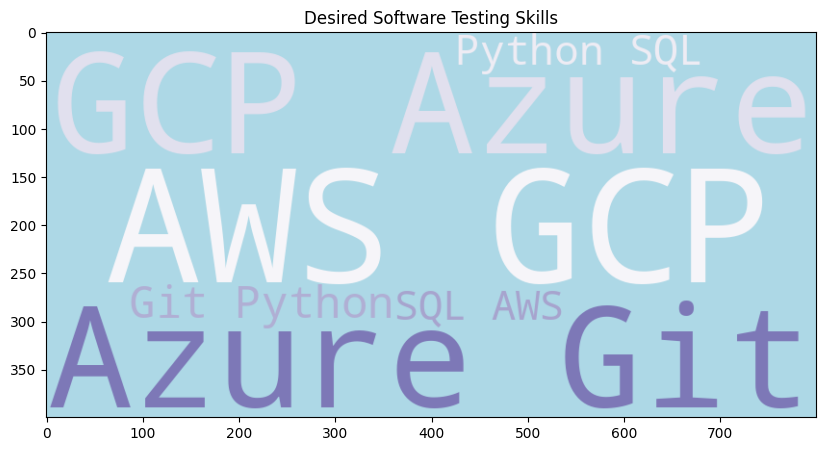

In [9]:
# Create a word cloud
text = " ".join(skills for skills in jobs_data.Skills.astype(str))
stopwords = set(STOPWORDS)
wordcloud = WordCloud().generate(text)

# Customise the word cloud
wordcloud = WordCloud(width=800, height=400, stopwords = stopwords, background_color='lightblue', max_words=100, colormap='Purples_r').generate(text) # https://www.geeksforgeeks.org/python/generating-word-cloud-python
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('on')
plt.title("Desired Software Testing Skills")
plt.show()

In [37]:
# Prepare data for Palladio GIS processing as well as possible

# Remove repetitions
jobs_data.drop_duplicates(inplace = True)
jobs_data.head()
jobs_data.to_csv("updated_jobs.csv")

location_data = jobs_data["Location"]
location_data.to_csv("locations.csv")
location_data.head()



,Location
0,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
1,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
2,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
3,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
4,📍\nUnited Kingdom\n🌐 Fully Remote\n⏰\nFull Time
